In [1]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
conf = (SparkConf()
            .setAppName('cluster')
            .setMaster('spark://spark-master:7077')
       )
conf.set("spark.executor.memory", "6g")
conf.set("spark.driver.maxResultSize", "0")
conf.set("spark.sql.shuffle.partitions", "5")
conf.set("spark.driver.memory", "3g")

spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [3]:
df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('escape', '"')
      .option('header', 'true')
      .load('hdfs://namenode:9000/data/process_scaled.csv') 
     )

In [4]:
df.show()

+------------+------------+-------------+--------------------+--------------------+--------+------------+--------------+----------+--------------------+-----------------+---------------------+
|   user_name|process_name|process_count|        command_line|        process_path|is_admin|trusted_path|argument_count|path_count|process_count_scaled|path_count_scaled|argument_count_scaled|
+------------+------------+-------------+--------------------+--------------------+--------+------------+--------------+----------+--------------------+-----------------+---------------------+
| WRK-ATURING|DWHWizrd.exe|           15|C:\PROGRA~2\Syman...|C:\PROGRA~2\Syman...|       1|           1|             1|        13|          -1.8560556|       -2.1957655|           -0.3038338|
|    WRK-BTUN|DWHWizrd.exe|           15|C:\PROGRA~2\Syman...|C:\PROGRA~2\Syman...|       1|           1|             1|        13|          -1.8560556|       -2.1957655|           -0.3038338|
| WRK-FMALTES|DWHWizrd.exe|        

In [12]:
from pyspark.ml.feature import VectorAssembler
kmeans_df = VectorAssembler(inputCols=['is_admin', 'trusted_path', 'process_count_scaled', 'path_count_scaled', 'argument_count_scaled'], outputCol='features').transform(df)
kmeans_df.cache()

DataFrame[user_name: string, process_name: string, process_count: int, command_line: string, process_path: string, is_admin: int, trusted_path: int, argument_count: int, path_count: int, process_count_scaled: double, path_count_scaled: double, argument_count_scaled: double, features: vector]

In [13]:
kmeans_df.show(5)

+-----------+------------+-------------+--------------------+--------------------+--------+------------+--------------+----------+--------------------+-----------------+---------------------+--------------------+
|  user_name|process_name|process_count|        command_line|        process_path|is_admin|trusted_path|argument_count|path_count|process_count_scaled|path_count_scaled|argument_count_scaled|            features|
+-----------+------------+-------------+--------------------+--------------------+--------+------------+--------------+----------+--------------------+-----------------+---------------------+--------------------+
|WRK-ATURING|DWHWizrd.exe|           15|C:\PROGRA~2\Syman...|C:\PROGRA~2\Syman...|       1|           1|             1|        13|          -1.8560556|       -2.1957655|           -0.3038338|[1.0,1.0,-1.85605...|
|   WRK-BTUN|DWHWizrd.exe|           15|C:\PROGRA~2\Syman...|C:\PROGRA~2\Syman...|       1|           1|             1|        13|          -1.85605

In [14]:
from pyspark.ml.clustering import KMeans
cost = np.zeros(20)  # create numpy array of shape (20,)
for _k in range(2,20):  # iterate over 20 iterations of k
    kmeans = KMeans(k=_k, seed=1, featuresCol='features')  # create a kmeans object
    model = kmeans.fit(kmeans_df.sample(False,0.1, seed=42))  # fit the kmeans object to a 10% sample from the dataset 
    cost[_k] = model.computeCost(kmeans_df)  # set the k,th index in cost to the sum of squared error 

Text(0, 0.5, 'cost')

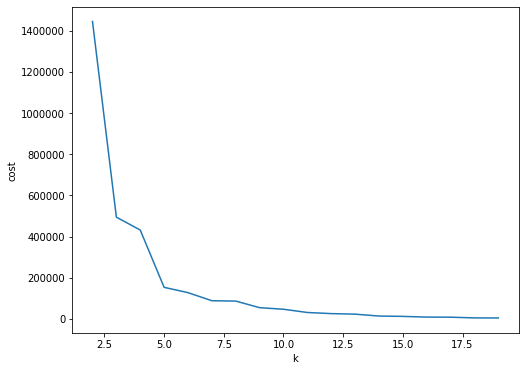

In [15]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

## Fit the data to kmeans
+ kmeans algorithm assigns obs to the nearest centroid until the centroid and obs converge

In [16]:
k = 10
kmeans = KMeans(k=k, seed=1, featuresCol='features')
model = kmeans.fit(kmeans_df)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 1.          1.          0.01967771  0.5779517  -0.30378973]
[ 1.         1.         1.5713121  0.5779517 -0.3038338]
[ 2.21582096e-04  1.00000000e+00 -1.62891307e+00 -2.14549653e+00
  5.18516348e+00]
[ 0.99857463  0.99986425 -1.64643465 -1.6465171   1.64252867]
[ 0.99987327  1.         -0.76860987 -1.5243467  -0.3038338 ]
[ 0.          1.         -1.6153581  -2.1427593  11.39353923]
[1.         1.         1.5713121  0.5779517  0.37170056]
[ 0.99978388  1.          1.5713121  -2.1677477   1.04927888]
[ 0.96408633  0.99533633 -1.51224404 -1.71323803  0.23220603]
[ 0.          0.99697885 -1.61676569 -2.14307986  3.07587889]


## Apply the kmeans estimater to all the rows in the dataset using the transform()

In [17]:
df_transformed = model.transform(kmeans_df)

In [18]:
df_transformed.select('user_name', 'process_name', 'prediction').sample(False, .2).show()

+-----------+------------+----------+
|  user_name|process_name|prediction|
+-----------+------------+----------+
|WRK-ABUNGST|DWHWizrd.exe|         8|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
|  billy.tun|  chrome.exe|         5|
+-----------+------------+----------+
only showing top 20 rows



## Plot dimensions: trusted_path, process_count_scaled, path_count_scaled

In [19]:
df_transformed_pd = df_transformed.toPandas()

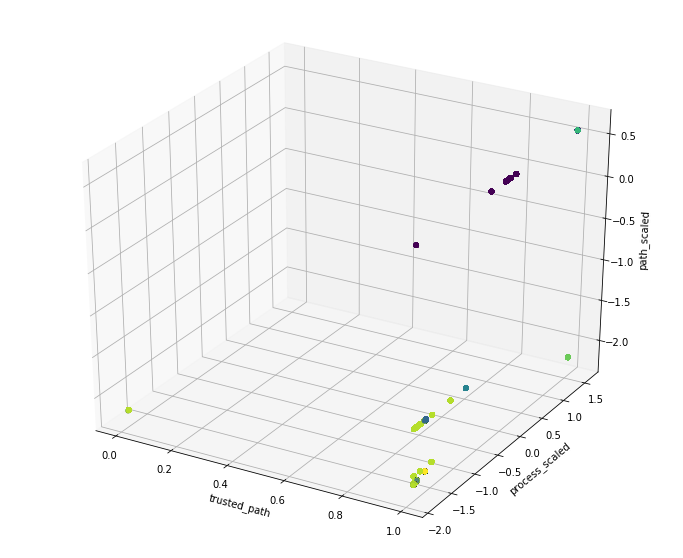

In [20]:
_plt = plt.figure(figsize=(12,10)).gca(projection='3d')
_plt.scatter(df_transformed_pd.trusted_path, df_transformed_pd.process_count_scaled, df_transformed_pd.path_count_scaled, c=df_transformed_pd.prediction)
_plt.set_xlabel('trusted_path')
_plt.set_ylabel('process_scaled')
_plt.set_zlabel('path_scaled')
plt.show()

## Plot dimensions: argument_count_scaled, process_count_scaled, path_count_scaled

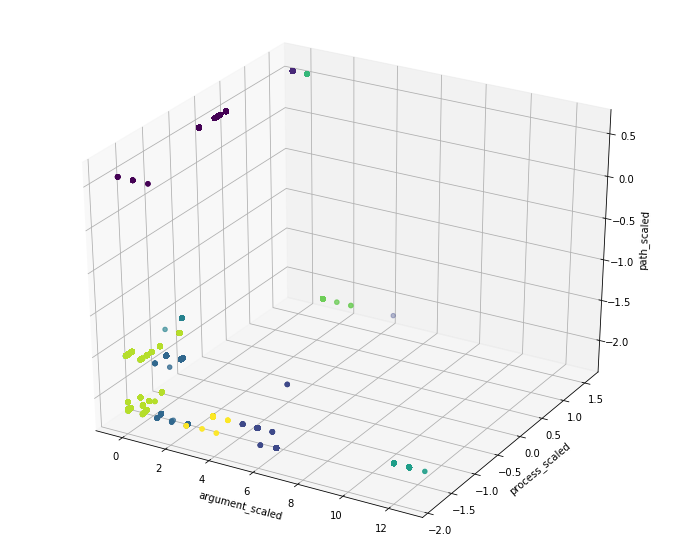

In [24]:
_plt = plt.figure(figsize=(12,10)).gca(projection='3d')
_plt.scatter(df_transformed_pd.argument_count_scaled, df_transformed_pd.process_count_scaled, df_transformed_pd.path_count_scaled, c=df_transformed_pd.prediction)
_plt.set_xlabel('argument_scaled')
_plt.set_ylabel('process_scaled')
_plt.set_zlabel('path_scaled')
plt.show()

## Plot dimensions: trusted_path_scaled, argument_count_scaled, path_count_scaled

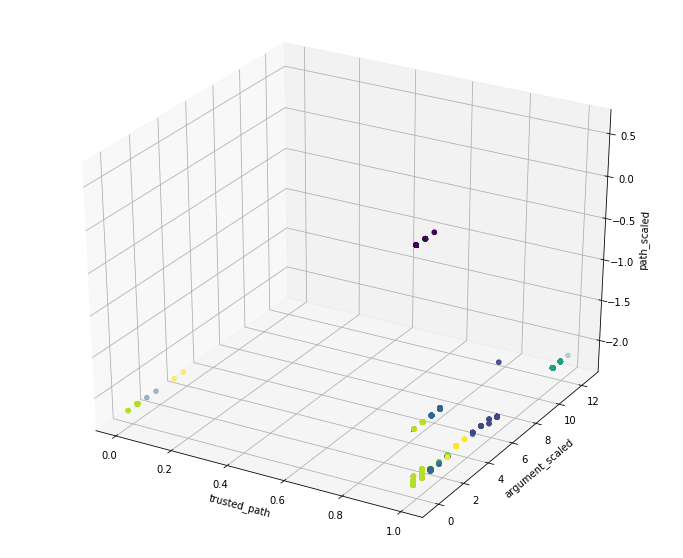

In [27]:
_plt = plt.figure(figsize=(12,10)).gca(projection='3d')
_plt.scatter(df_transformed_pd.trusted_path, df_transformed_pd.argument_count_scaled, df_transformed_pd.path_count_scaled, c=df_transformed_pd.prediction)
_plt.set_xlabel('trusted_path')
_plt.set_ylabel('argument_scaled')
_plt.set_zlabel('path_scaled')
plt.show()